Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

- _The presence of words are enough to know that they are within context of the article_
- _Bag of Words is a case use for this_

## Follow Along

In [1]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

Text is from this BBC article [Baiase: A Roman settlement at the bottom of the sea](http://www.bbc.com/travel/story/20200713-baiae-a-roman-settlement-at-the-bottom-of-the-sea?referer=https%3A%2F%2Fwww.bbc.com%2F)

In [2]:
text = 'I laughed nervously. “I wish you’d told me that when we were over there. Why are you telling me that when we’re here?” We were overlooking one of the fumaroles of Campi Flegrei, known in English as the Phlegraean Fields. One of 20 known “supervolcanoes” on the planet – capable of erupting with a volume thousands of times stronger than an average volcano – Campi Flegrei commands less notoriety than Mt Vesuvius, just 30km to the west. But that is largely down to luck. If Campi Flegrei were to blow at maximum capacity today, it would make the 79AD eruption of Mt Vesuvius that destroyed Pompeii look like a puppy’s sneeze. Fortunately, Campi Flegrei hasn’t had a full-force eruption in thousands of years. That isn’t to say it’s impossible. Researchers call the supervolcano “restless”, and there are concerns it is becoming more so. In 2012, the alert level was raised from green to yellow, indicating a need for more monitoring. Most recently, a “seismic swarm” in April 2020 saw 34 different earthquakes.'

In [3]:
doc = nlp(text)

print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['laugh', 'nervously', 'wish', 'tell', 'tell', 'overlook', 'fumarole', 'Campi', 'Flegrei', 'know', 'English', 'Phlegraean', 'Fields', '20', 'know', 'supervolcanoe', 'planet', 'capable', 'erupt', 'volume', 'thousand', 'time', 'strong', 'average', 'volcano', 'Campi', 'Flegrei', 'command', 'notoriety', 'Mt', 'Vesuvius', '30', 'km', 'west', 'largely', 'luck', 'Campi', 'Flegrei', 'blow', 'maximum', 'capacity', 'today', '79ad', 'eruption', 'Mt', 'Vesuvius', 'destroy', 'Pompeii', 'look', 'like', 'puppy', 'sneeze', 'fortunately', 'Campi', 'Flegrei', 'force', 'eruption', 'thousand', 'year', 'impossible', 'researcher', 'supervolcano', 'restless', 'concern', '2012', 'alert', 'level', 'raise', 'green', 'yellow', 'indicate', 'need', 'monitoring', 'recently', 'seismic', 'swarm', 'April', '2020', 'see', '34', 'different', 'earthquake']


In [4]:
# get all the data at once

import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [5]:
data = gather_data('./data')

In [6]:
len(data)

401

In [7]:
# first 50 words in first article
data[0][:50]

b'Freeze on anti-spam campaign\n\nA campaign by Lycos '

In [8]:
data[0]

b'Freeze on anti-spam campaign\n\nA campaign by Lycos Europe to target spam-related websites appears to have been put on hold.\n\nEarlier this week the company released a screensaver that bombarded the sites with data to try to bump up the running costs of the websites. But the site hosting the screensaver now displays a pink graphic and the words "Stay tuned". No one at Lycos was available for comment on latest developments in its controversial anti-spam campaign.\n\nLycos Europe\'s "Make love not spam" campaign was intended as a way for users to fight back against the mountain of junk mail flooding inboxes. People were encouraged to download the screensaver which, when their PC was idle, would then send lots of data to sites that peddle the goods and services mentioned in spam messages. Lycos said the idea was to get the spam sites running at 95% capacity and generate big bandwidth bills for the spammers behind the sites. But the plan has proved controversial.\n\nMonitoring firm Netc

In [9]:
# alex kim lecture

# def gather

# from glob import glob
# file_list = glob(filefolder + '/*.txt')


# for article in file_list:
#     with open(article, 'rb') as f:
#         data.append(f.read())
# len(data)

### CountVectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
# get paragraphs
# split is a string method to use to turn text into a list (documents) - paragraphs
# strip removes new line characters (\n)
# text = text.split('\n')

# when dealing with 1 line of text - no paragraphs
text = text.split('. ')
print(type(text))

<class 'list'>


In [11]:
print(text)

['I laughed nervously', '“I wish you’d told me that when we were over there', 'Why are you telling me that when we’re here?” We were overlooking one of the fumaroles of Campi Flegrei, known in English as the Phlegraean Fields', 'One of 20 known “supervolcanoes” on the planet – capable of erupting with a volume thousands of times stronger than an average volcano – Campi Flegrei commands less notoriety than Mt Vesuvius, just 30km to the west', 'But that is largely down to luck', 'If Campi Flegrei were to blow at maximum capacity today, it would make the 79AD eruption of Mt Vesuvius that destroyed Pompeii look like a puppy’s sneeze', 'Fortunately, Campi Flegrei hasn’t had a full-force eruption in thousands of years', 'That isn’t to say it’s impossible', 'Researchers call the supervolcano “restless”, and there are concerns it is becoming more so', 'In 2012, the alert level was raised from green to yellow, indicating a need for more monitoring', 'Most recently, a “seismic swarm” in April 20

In [12]:
# how many sentences
len(text)


11

In [13]:
# list comprehension on text for things longer than zero
# sort out empty sentences

text = [t for t in text if len(t) > 0]
print(text)
print(len(text))

['I laughed nervously', '“I wish you’d told me that when we were over there', 'Why are you telling me that when we’re here?” We were overlooking one of the fumaroles of Campi Flegrei, known in English as the Phlegraean Fields', 'One of 20 known “supervolcanoes” on the planet – capable of erupting with a volume thousands of times stronger than an average volcano – Campi Flegrei commands less notoriety than Mt Vesuvius, just 30km to the west', 'But that is largely down to luck', 'If Campi Flegrei were to blow at maximum capacity today, it would make the 79AD eruption of Mt Vesuvius that destroyed Pompeii look like a puppy’s sneeze', 'Fortunately, Campi Flegrei hasn’t had a full-force eruption in thousands of years', 'That isn’t to say it’s impossible', 'Researchers call the supervolcano “restless”, and there are concerns it is becoming more so', 'In 2012, the alert level was raised from green to yellow, indicating a need for more monitoring', 'Most recently, a “seismic swarm” in April 20

In [14]:
# type(dtm.todense())

In [15]:
'''
Instanciate, fit and transfrom

fit: what we learn the vocab with and what we count against

transform: count the words that we see from what we found when we fit
'''
# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.

# The vocabulary dictionary does not represent the counts of words!!

In [16]:
# get_feature_names = words that are in vocab
print(vect.get_feature_names())

['20', '2012', '2020', '30km', '34', '79ad', 'alert', 'an', 'and', 'april', 'are', 'as', 'at', 'average', 'becoming', 'blow', 'but', 'call', 'campi', 'capable', 'capacity', 'commands', 'concerns', 'destroyed', 'different', 'down', 'earthquakes', 'english', 'erupting', 'eruption', 'fields', 'flegrei', 'for', 'force', 'fortunately', 'from', 'full', 'fumaroles', 'green', 'had', 'hasn', 'here', 'if', 'impossible', 'in', 'indicating', 'is', 'isn', 'it', 'just', 'known', 'largely', 'laughed', 'less', 'level', 'like', 'look', 'luck', 'make', 'maximum', 'me', 'monitoring', 'more', 'most', 'mt', 'need', 'nervously', 'notoriety', 'of', 'on', 'one', 'over', 'overlooking', 'phlegraean', 'planet', 'pompeii', 'puppy', 'raised', 're', 'recently', 'researchers', 'restless', 'saw', 'say', 'seismic', 'sneeze', 'so', 'stronger', 'supervolcano', 'supervolcanoes', 'swarm', 'telling', 'than', 'that', 'the', 'there', 'thousands', 'times', 'to', 'today', 'told', 'vesuvius', 'volcano', 'volume', 'was', 'we', '

In [17]:
text[:25]

['I laughed nervously',
 '“I wish you’d told me that when we were over there',
 'Why are you telling me that when we’re here?” We were overlooking one of the fumaroles of Campi Flegrei, known in English as the Phlegraean Fields',
 'One of 20 known “supervolcanoes” on the planet – capable of erupting with a volume thousands of times stronger than an average volcano – Campi Flegrei commands less notoriety than Mt Vesuvius, just 30km to the west',
 'But that is largely down to luck',
 'If Campi Flegrei were to blow at maximum capacity today, it would make the 79AD eruption of Mt Vesuvius that destroyed Pompeii look like a puppy’s sneeze',
 'Fortunately, Campi Flegrei hasn’t had a full-force eruption in thousands of years',
 'That isn’t to say it’s impossible',
 'Researchers call the supervolcano “restless”, and there are concerns it is becoming more so',
 'In 2012, the alert level was raised from green to yellow, indicating a need for more monitoring',
 'Most recently, a “seismic swarm” i

In [18]:
# document term matrix
# sparce matrix = dealing with a lot of zeros
# (Document, Term) Count
print(dtm)

  (0, 52)	1
  (0, 66)	1
  (1, 60)	1
  (1, 71)	1
  (1, 93)	1
  (1, 95)	1
  (1, 100)	1
  (1, 105)	1
  (1, 106)	1
  (1, 108)	1
  (1, 110)	1
  (1, 115)	1
  (2, 10)	1
  (2, 11)	1
  (2, 18)	1
  (2, 27)	1
  (2, 30)	1
  (2, 31)	1
  (2, 37)	1
  (2, 41)	1
  (2, 44)	1
  (2, 50)	1
  (2, 60)	1
  (2, 68)	2
  (2, 70)	1
  :	:
  (9, 32)	1
  (9, 35)	1
  (9, 38)	1
  (9, 44)	1
  (9, 45)	1
  (9, 54)	1
  (9, 61)	1
  (9, 62)	1
  (9, 65)	1
  (9, 77)	1
  (9, 94)	1
  (9, 98)	1
  (9, 104)	1
  (9, 114)	1
  (10, 2)	1
  (10, 4)	1
  (10, 9)	1
  (10, 24)	1
  (10, 26)	1
  (10, 44)	1
  (10, 63)	1
  (10, 79)	1
  (10, 82)	1
  (10, 84)	1
  (10, 90)	1


In [19]:
# Dealing with Sparse Matrix
# tidy data format
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0]])

In [20]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [21]:
# Get Word Counts for each document
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,20,2012,2020,30km,34,79ad,alert,an,and,april,...,were,west,when,why,wish,with,would,years,yellow,you
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Going back to the data in text files

In [22]:
data[0][:25]

b'Freeze on anti-spam campa'

In [23]:
len(data)

401

In [23]:
type(data[0])

bytes

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [24]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

'''IMPORT'''
from sklearn.feature_extraction.text import CountVectorizer

'''INSTANCIATE'''
# vect = CountVectorizer(stop_words='english', max_features=1000)
# Jon Cody
vect = CountVectorizer(stop_words=nlp.Defaults.stop_words, max_features=1000)

'''FIT'''
#Learn our Vocab
vect.fit(data)

'''TRANSFROM'''
# Get sparse dtm
dtm = vect.transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

/home/regina/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
dtm.head()

,000,10,100,11,12,14,15,18,20,200,...,worldwide,worm,worth,writing,xbox,xp,yahoo,year,years,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,4,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# check shape
dtm.shape

(401, 1000)

# Just counting words does not help with seeing corrilation

In [27]:
# lenght of characters not words
doc_len = [len(doc) for doc in data]

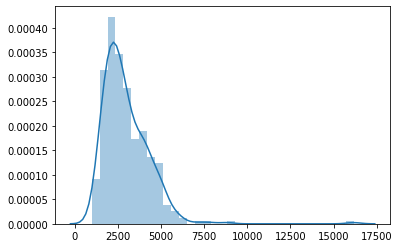

In [28]:
import seaborn as sns

# notice outliers - docs that are really long
sns.distplot(doc_len);

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

normaized between 0-1
helps control or penelize words - help filter out noise
helps find what is unique in documents and in corpus

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
'''FIT AND TRANSFROM - use on training data'''
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,000,10,100,101,104,10m,11,12,120,13,...,yoda,yoran,york,young,younger,youngsters,youth,zafi,zen,zombies
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016605,0.019120,0.023989,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.037624,0.043323,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.069269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.051229,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### refine the results

In [30]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

Ingram or a multi-word phrase
- text data machines

Bigrams 
- "text data"
- "data machines"
- "text machines"

Trigrams
- 'text data machine'
- 'data machines Tiktok'

In [31]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97, # set the size of the dataset - ingram has to be w/i 0-97 of documents
                        min_df=3,   # sets the size of the dataset - ingram has to be in at least 3 documents
                        max_features = 8000,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,10,15,2004,50,ability,accord,add,airline,announce,anti,...,£ 11.5,£ 132,"£ 2,000",£ 20,£ 339,£ 4.99,£ 40,£ 5,£ 50,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.046531,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.053639,0.0,0.0,0.0,0.0,0.050289


In [32]:
dtm.shape

(401, 8000)

## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

measuring similarity between two points - SKLEARN METHOD - inorder to know this I have to know the similarity of all other points too. 
This methods measures 1 item to all other items

In [33]:
# Calculate Distance of TF-IDF Vectors
from sklearn.metrics.pairwise import cosine_similarity

dist_matrix  = cosine_similarity(dtm)

In [34]:
# Turn it into a DataFrame

df = pd.DataFrame(dist_matrix)

In [35]:
# Our Similarity Matrix is ? size 
# distance from 1 article to all other articles
df.shape

(401, 401)

In [36]:
data[0][:100]

b'Freeze on anti-spam campaign\n\nA campaign by Lycos Europe to target spam-related websites appears to '

In [37]:
# Each row is the similarity of one document to all other documents (including itself)
# index 0 here is actually it being compaired to it's self
df[0][:5]

0    1.000000
1    0.054894
2    0.016689
3    0.025872
4    0.024183
Name: 0, dtype: float64

In [38]:
# Grab the row
# get similarity of 1 document - use sort values
df[df[0] < 1][0].sort_values(ascending=False)[:5]

0      1.000000
39     1.000000
392    0.657965
356    0.531453
32     0.263311
Name: 0, dtype: float64

In [39]:
# chosen article
print(data[0][:150])

b'Freeze on anti-spam campaign\n\nA campaign by Lycos Europe to target spam-related websites appears to have been put on hold.\n\nEarlier this week the comp'


In [40]:
# article similar to chosen
# AKA the new recomendation
print(data[392][:150])

b'Anti-spam screensaver scrapped\n\nA contentious campaign to bump up the bandwidth bills of spammers by flooding their sites with data has been dropped.\n'


^^^ There  is a limitation with the SKLearn model (cosign similarity). The BBC example has data that is constatnly growing exponentaly, trying to keep up with the new
data would kill our memory^^^

### NearestNeighbor (K-NN) 

To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. The basic idea is that if point  is very distant from point , and point  is very close to point , then we know that points  and  are very distant, without having to explicitly calculate their distance. In this way, the computational cost of a nearest neighbors search can be reduced to  or better. This is a significant improvement over brute-force for large data.

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid  and radius , such that each point in the node lies within the hyper-sphere defined by  and . The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

In [41]:
dtm.head()

,10,15,2004,50,ability,accord,add,airline,announce,anti,...,£ 11.5,£ 132,"£ 2,000",£ 20,£ 339,£ 4.99,£ 40,£ 5,£ 50,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.046531,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.053639,0.0,0.0,0.0,0.0,0.050289


In [42]:
from sklearn.neighbors import NearestNeighbors
# metric = 'minkowski' is a distance metric


# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [43]:
# what is close to my first observation
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 0.        , 0.82708562, 0.96803639, 1.2138277 ]]),
 array([[  0,  39, 392, 356,  32]]))

In [44]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[202]])

(array([[0.        , 0.92992805, 1.05799197, 1.05799197, 1.16629403]]),
 array([[202, 223, 279, 353, 291]]))

In [45]:
data[202][:200]

b'Warnings on woeful wi-fi security\n\nCompanies are getting worse at keeping their wireless data networks secure.\n\nA survey of wi-fi networks in London, Frankfurt, New York and San Francisco by RSA Secur'

In [46]:
data[223][:200]

b"'Evil twin' fear for wireless net\n\nPeople using wireless high-speed net (wi-fi) are being warned about fake hotspots, or access points.\n\nThe latest threat, nicknamed evil twins, pose as real hotspots "

In [47]:
rndm_tech_article = [ """
Final Fantasy VII Remake and Marvel’s Avengers, two of this year’s major releases, have both been postponed. Square Enix, the publisher behind the titles, announced the news Tuesday morning.

Avengers is being pushed back four months, with its new release date set for September 4. The arrival of Final Fantasy VII Remake has been bumped by one month, moving from March 3 to April 10.

Delays for massive blockbuster games are common around this time of year. With the industry preparing for big, anticipated releases slated for spring, summer and the holidays, the news from Square Enix isn’t all that surprising. Early builds for Marvel’s Avengers received a mixed reception at E3 2019 and subsequent, similar events. Final Fantasy VII fans will likely have a critical eye when revisiting the classic, setting a high bar for developers to clear.

Final Fantasy VII Remake is among The Washington Post's most anticipated games of 2020.

“We are making this tough decision in order to give ourselves a few extra weeks to apply final polish to the game and to deliver you with the best possible experience,” wrote Final Fantasy VII Remake producer Yoshinori Kitase in a statement. “I, on behalf of the whole team, want to apologize to everyone, as I know this means waiting for the game just a little bit longer.”

Marvel’s Avengers’s developer Crystal Dynamics released a similar statement, with studio co-heads Scot Amos and Ron Rosenberg citing “fine tuning and polishing” as the reason for the delay. “We will spend this additional development time focusing on fine tuning and polishing the game to the high standards our fans expect and deserve.”

"""]


In [48]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(rndm_tech_article)

In [49]:
new

<1x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 98 stored elements in Compressed Sparse Row format>

In [50]:
nn.kneighbors(new.todense()) # distances are increasing here

(array([[1.30401736, 1.30684711, 1.30713661, 1.31127454, 1.31194168]]),
 array([[ 28, 321, 163,  93, 143]]))

In [51]:
# Inspect Most relevant result
data[28]

b"The gaming world in 2005\n\nIf you have finished Doom 3, Half Life 2 and Halo 2, don't worry. There's a host of gaming gems set for release in 2005.\n\n WORLD OF WARCRAFT \n\nThe US reception to this game from developers Blizzard has been hugely enthusiastic, with the title topping its competitors in the area of life-eating, high-fantasy, massively multiplayer role-player gaming. Solid, diverse, accessible and visually striking, it may well open up the genre like never before. If nothing else, it will develop a vast and loyal community. Released 25 February on PC. ICO 2 (WORKING TITLE) Ico remains a benchmark for PS2 gaming, a title that took players into a uniquely atmospheric and artistic world of adventure. The (spiritual) sequel has visuals that echo those of the original, but promises to expand the Ico world, with hero Wanda taking on a series of giants. The other known working title is Wanda And Colossus. Release date to be confirmed on PS2. THE LEGEND OF ZELDA \n\nThe charisma

^^^ There is a limitation with Nearest Neighbors too - if a document doesn't have a lot of values in it's vector (lots of zeros), then measure the similarity,
then it will be similar or not very distant from the document in question. For example only 98 stored elements in this article were a hit with the orginal. In this case a good idea would be to have a threshold as a requitement. For example in this instance above, the threashold would be articles < 1.28 distance only

From Jon Cody Lecture:
"How would I set a distance threshold for recommendations for my KNN model?

1. Select a sample size of query articles (10 for example)
2. Get the KNN recommendations for those 10 articles ~5 articles each
3. For each of the 50 recommendations, I would label them as `useful` or `not useful`
4. Take one of the following values as the threshold:
        - Maxium Distance of the `useful` labled recommendations
        - 75% percentile of `useful` labled recommendations
        - Minimum of the `not useful` labled recommnedations
        
Then after the model is in production, run a simliar test using A/B testing

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

EXAMPLE: DUCK (ANIMAL) AND DUCK (ACTION) ARE TAKEN AS THE SAME THING. bow LOSES THIS CONCEPTIAL LANGUAGE PROCESS AND GRAMMER
BOW WORKS BETTER ON SMALLER DATASETS THAT ARE HIGHLY SPECIALIZED

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

WORD EMBEDDINGS HELPS KEEP THE CONCEPTUAL PARTS OF LANGUAGE
DOES NOT WORK GREAT ON SUPER SPECIALIED USE CASES - LIKES MORE GERNERALIZED MATERIAL

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [52]:
# Process a text
nlp = spacy.load('en_core_web_lg')

doc = nlp("Two bananas in pyjamas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector
print(bananas_vector)

[ 2.07984239e-01 -2.60890484e-01 -1.15457252e-01 -1.96443751e-01
 -2.83249468e-03  3.55849974e-02 -2.05170006e-01 -2.27374747e-01
  8.56052488e-02  1.36894751e+00 -5.74124977e-02  8.06210041e-02
  2.37275064e-02  1.17454052e-01 -6.53099641e-03 -1.24400005e-01
  1.99086756e-01  6.37722552e-01  1.52916998e-01 -2.33504996e-01
 -2.40909994e-01 -7.11500049e-02 -9.10753161e-02  7.16734976e-02
  1.16262749e-01 -3.91372502e-01  1.13048747e-01 -2.11327493e-01
  1.09019078e-01 -2.44885415e-01  3.00577488e-02  4.77855802e-02
  7.37800002e-02  2.57142037e-01  2.62586236e-01 -1.66897491e-01
  1.87596500e-01 -1.23680010e-02 -1.76299751e-01  1.11685000e-01
  1.82024967e-02  9.86500084e-03 -3.58770013e-01 -2.23265499e-01
 -4.37720008e-02  3.63999486e-01  7.42954984e-02  1.21225506e-01
  1.37013003e-01 -5.50666526e-02  2.66017504e-02  8.87180045e-02
 -1.14092499e-01 -2.02865750e-01  3.63092512e-01 -3.08394760e-01
  1.13859497e-01  3.13650146e-02  2.62076259e-01  1.90399922e-02
  7.24634901e-02  2.79004

In [53]:
len(bananas_vector)

300

In [54]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I like dogs.")

# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.6325916466756616


In [65]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words): # extract word vector from each listed word
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'suv', 'sith', 'jedi', 'yoda', 'race', 'elves', 'dragon', 'sword', 'king', 'queen', 'prince', 'horse', 'fish' , 'lion', 'tiger', 'lynx', 'potato', 'obi-wan' , 'optimus prime', 'garfield']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[ 4.5914829 ,  2.81437746],
       [ 4.42898426,  2.34864972],
       [ 2.74026626,  3.798202  ],
       [-4.56233103,  2.32284021],
       [-4.28190055,  2.2096981 ],
       [-3.66568679,  2.85204365],
       [ 2.95746995,  0.0700057 ],
       [-1.55099474, -0.47875859],
       [-1.03261548, -1.92496344],
       [-1.81020759, -1.55041182],
       [-0.45826439, -2.74875731],
       [-0.11936527, -2.36754599],
       [-0.83363571, -1.89212056],
       [ 1.920573  , -1.1262271 ],
       [ 2.00382944, -2.64390148],
       [-0.07281163, -2.26223633],
       [ 0.25699471, -1.95138333],
       [-0.15131895, -0.32130187],
       [ 1.62906847, -0.97323384],
       [-0.86313608,  0.88846533],
       [-0.14532111,  1.07746555],
       [-0.98107968,  1.85909396]])

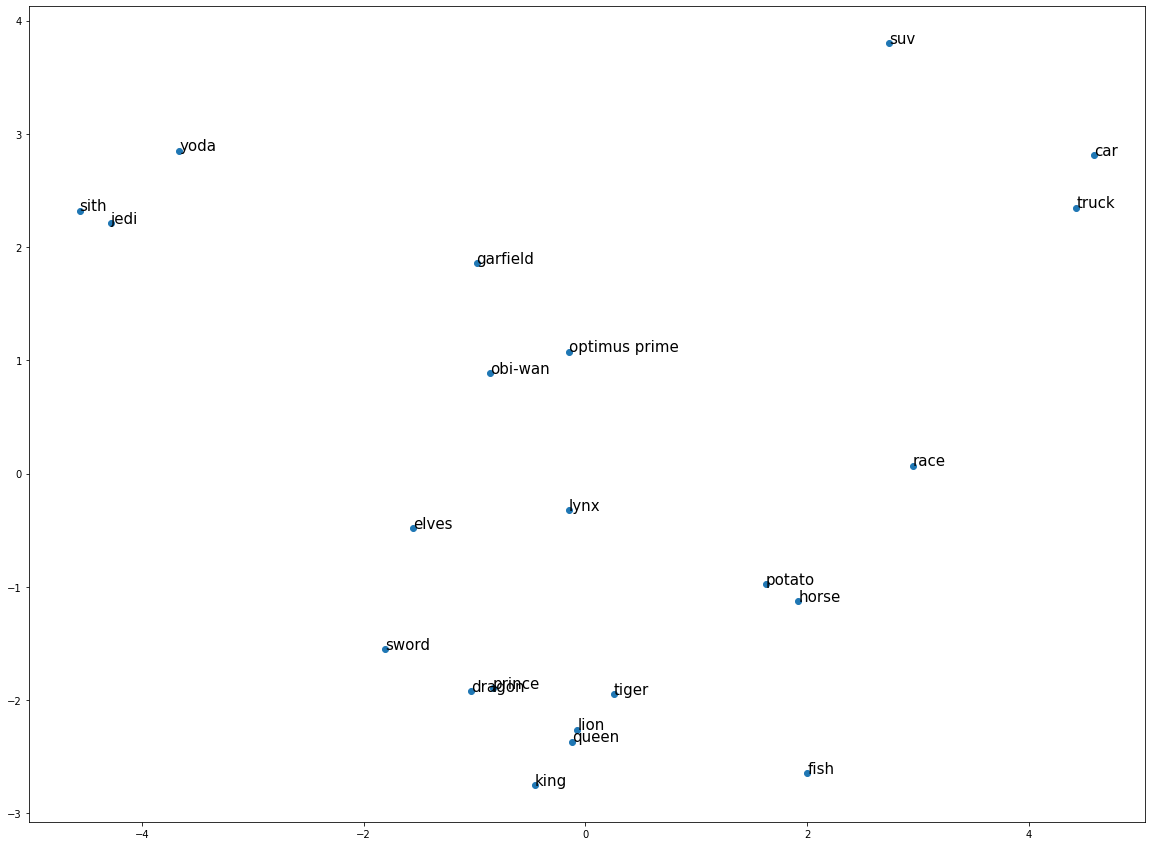

In [66]:
# create a nice big plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.show()

## Follow Along
### Extract Document Vectors

Let's see how much the quality of our query will work when we try a new embedding model.

Steps:
* Extract Vectors from Each Document
* Search using KNN


In [57]:
X = [nlp(str(d)).vector for d in data]

In [58]:
pd.DataFrame(X).shape

(401, 300)

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

# Review
For your module project assignment you will create vector representations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf